<a href="https://colab.research.google.com/github/lapythie/dl/blob/master/DL_HW01_numpy_binary_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

import torch
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms

import matplotlib.pyplot as plt

from tqdm import tqdm

import time

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

In [ ]:
train_dataset = MNIST('.', train=True, download=True, 
                      transform=transform)
test_dataset = MNIST('.', train=False,
                     transform=transform)

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
train_dataset.data = train_dataset.data[(train_dataset.targets == 3)
                                        |(train_dataset.targets == 7)]
train_dataset.targets = train_dataset.targets[(train_dataset.targets == 3)
                                              |(train_dataset.targets == 7)]

In [ ]:
test_dataset.data = test_dataset.data[(test_dataset.targets == 3)
                                      |(test_dataset.targets == 7)]
test_dataset.targets = test_dataset.targets[(test_dataset.targets == 3)
                                            |(test_dataset.targets == 7)]

In [ ]:
# self.long() is equivalent to self.to(torch.int64)
train_dataset.targets = (train_dataset.targets == 7).long()
test_dataset.targets = (test_dataset.targets == 7).long()

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

# Домашка

In [355]:
def my_tanh(x):
    return (np.e**x - np.e**(-x))/(np.e**x + np.e**(-x))

# def my_relu(x):
#     if x > 0:
#         return x
#     else:
#         return 0

def my_sygmoid(x):
    return 1/(1+np.e**(-x))
    
def my_mean_batch_bce_loss(y_true, y_predicted):
    # assert y_true.shape == y_predicted.shape
    loss = -(np.matmul(y_true.T, 
                    np.log(y_predicted)) +
            np.matmul((1 - y_true).T, 
                    np.log(1 - y_predicted)))
    return (loss/len(y_true)).mean()

In [358]:
%%time

# первый батч
for x, y in train_loader:
    x = x.view(x.shape[0], -1).numpy()
    y = np.expand_dims(y.numpy(), axis=1)
    break
    
n_neurons_1_layer = 4
n_neurons_output_layer = 1
weights_regularization = 0.001

# 1 Задайте обучаемые параметры
w1 = np.random.rand(x.shape[1], n_neurons_1_layer)
w1 = np.dot(w1, weights_regularization)
b1 = np.zeros((n_neurons_1_layer))
w2 = np.random.rand(n_neurons_1_layer, n_neurons_output_layer)
w2 = np.dot(w2, weights_regularization)
b2 = np.zeros((n_neurons_output_layer))

# 2 задайте скорость обучения, количество эпох
learning_rate = 0.001
epochs = 5

losses = []

for n_epoch in range(epochs):

    print(f'Epoch: {n_epoch + 1}.')

    for x, y in train_loader:

        x = x.view(x.shape[0], -1).numpy()
        y = np.expand_dims(y.numpy(), 1)

        # 3 сделайте линейную трансформацию через первый слой
        # (128, 8)
        linear_transformation_z1 = np.matmul(x, w1) + b1

        # 4 примените какую-нибудь нелинейную функцию активации
        non_linearity_a1 = my_tanh(linear_transformation_z1)

        # 5 сделайте линейную трансформацию через второй слой
        linear_transformation_z2 = np.matmul(non_linearity_a1, w2) + b2

        # 6 примените сигмоиду
        predictions = my_sygmoid(linear_transformation_z2)

        # 7 рассчитайте функцию потерь
        loss = my_mean_batch_bce_loss(y, predictions)

        # 8 сохраняйте значения функции потерь в массив losses
        losses.append(loss)

        # 9 возьмите производные от функции потерь к каждому обучаемому параметру
        # dloss_dw2 = (dloss_dpreds)*(dpreds_d_lin_tran_z2)*(d_lin_tran_z2_d_w2)

        dloss_dpreds = (1 - y)/(1 - predictions) - y/predictions
        dloss_dlin_tran_z2 = dloss_dpreds @ predictions.T @ (1 - predictions)
        # (1, 8)
        # d_loss_dw2 = np.matmul(dloss_dlin_tran_z2.T,  non_linearity_a1)
        # (8, 1) если умножать справа, то всё нормально:
        dloss_dw2 = np.matmul(non_linearity_a1.T, dloss_dlin_tran_z2)/x.shape[0] #делим на размер батча
        dloss_db2 = np.sum(dloss_dlin_tran_z2)/x.shape[0] #делим на размер батча

        dloss_dnon_lin_a1 = dloss_dlin_tran_z2 @ w2.T
        dloss_dlin_tran_z1 = dloss_dnon_lin_a1 * (1 - non_linearity_a1**2)
        dloss_dw1 = (x.T @ dloss_dlin_tran_z1)/x.shape[0] #делим на размер батча
        dloss_db1 = np.sum(dloss_dlin_tran_z1, axis=0)/x.shape[0] #делим на размер батча
        
        # 10 Обновите w1, b1, w2, b2 
        w2 = w2 - np.dot(learning_rate, dloss_dw2)
        b2 = b2 - np.dot(learning_rate, dloss_db2)
        w1 = w1 - np.dot(learning_rate, dloss_dw1)
        b1 = b1 - np.dot(learning_rate, dloss_db1)

Epoch: 1.
Epoch: 2.
Epoch: 3.
Epoch: 4.
Epoch: 5.
CPU times: user 10.8 s, sys: 8.11 s, total: 18.9 s
Wall time: 9.59 s


Mean loss: 0.07316660832013801


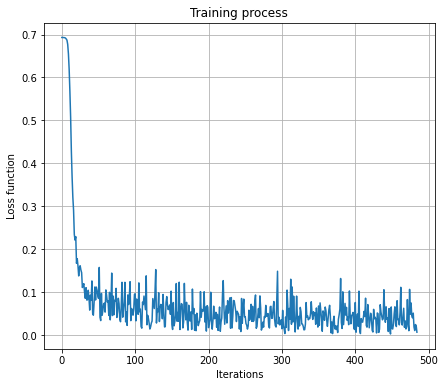

In [359]:
# 11 Нарисуйте график функции потерь
plt.figure(figsize=(7, 6))
plt.plot(losses)
plt.grid()
plt.title('Training process')
plt.xlabel('Iterations')
plt.ylabel('Loss function')
print(f'Mean loss: {np.mean(losses)}')

# Trash

In [ ]:
# x.shape #(128, 784)
# w1.shape #(784, 8)
# b1.shape #(128, 8)
# linear_transformation_z1.shape #(128, 8)
# non_linearity_a1.shape #(128, 8)
# linear_transformation_z2.shape #(128, 1)
# predictions.shape #(128, 1)
# loss #scalar

In [ ]:
for x, y in train_loader:
    x = x.view(x.shape[0], -1).numpy()
    y = np.expand_dims(y.numpy(), axis=1)
    break

In [ ]:
x.shape, y.shape

((128, 784), (128, 1))

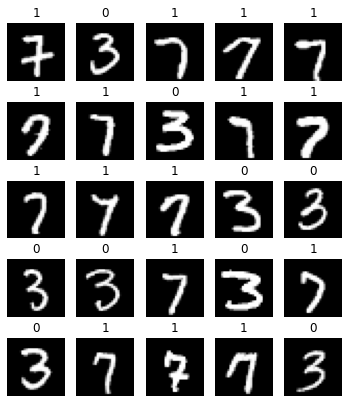

In [413]:
X, y = next(iter(test_loader))
X = X.numpy()
y = y.numpy()

plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

In [ ]:
print(my_tanh(1/7))
print(np.tanh(1/7))
print(np.tanh(1/7) == my_tanh(1/7))

0.14189319376693252
0.14189319376693255
False


In [365]:
for i in range(len(x)):
    if y[i]-predictions[i] > 0.5:
        print(y[i], predictions[i])

Inference

In [ ]:
for x, y in test_loader:

    x_test = x_test.view(x_test.shape[0], -1).numpy()
    y_test = np.expand_dims(y_test.numpy(), axis=1)

In [459]:
%%time
test_losses = []
test_targets = []
test_preds = []
n_neurons_1_layer = 4
n_neurons_output_layer = 1

for x, y in test_loader:

    x = x.view(x.shape[0], -1).numpy()
    y = np.expand_dims(y.numpy(), 1)
    
    for t in y:
        test_targets.append(t)

    linear_transformation_z1 = np.matmul(x, w1) + b1
    non_linearity_a1 = my_tanh(linear_transformation_z1)
    linear_transformation_z2 = np.matmul(non_linearity_a1, w2) + b2
    predictions = my_sygmoid(linear_transformation_z2)

    for p in predictions:
        test_preds.append(p)

    loss = my_mean_batch_bce_loss(y, predictions)
    test_losses.append(loss)

CPU times: user 353 ms, sys: 240 ms, total: 592 ms
Wall time: 311 ms


In [462]:
np.mean(test_losses)

0.06199907744569884

In [ ]:
indices = []
for i in range(len(test_preds)):
    if (test_preds[i] - test_targets[i]) > 0.5:
        # print(i, test_preds[i], test_targets[i])
        indices.append(i)

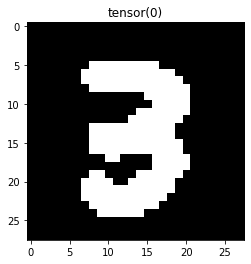

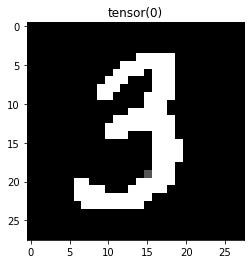

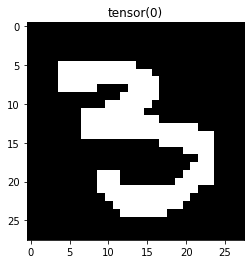

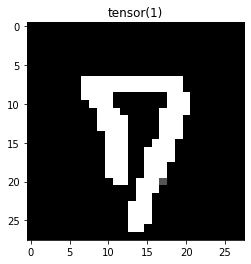

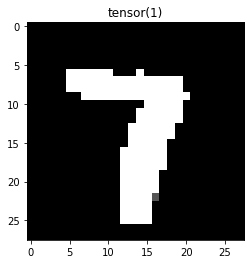

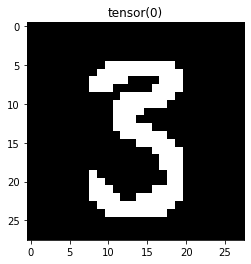

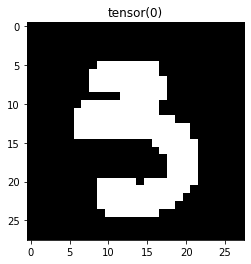

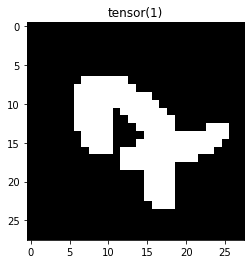

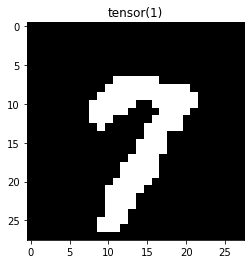

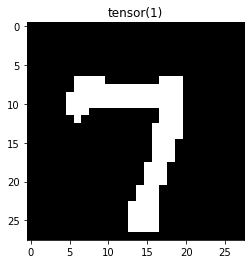

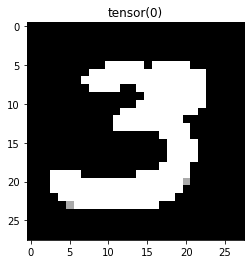

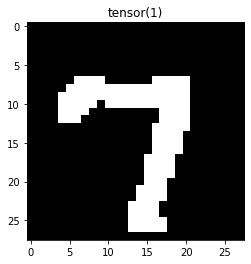

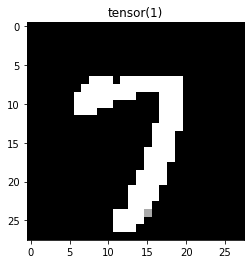

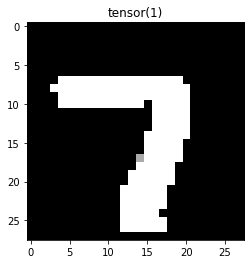

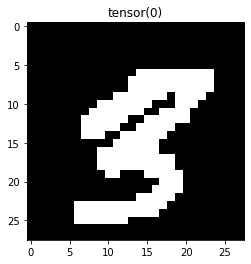

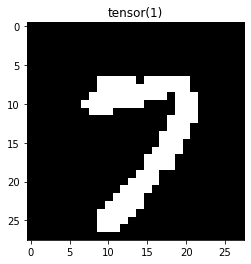

In [467]:
for i in indices:
    arr_ = np.squeeze(test_dataset.data[i])
    plt.title(test_dataset.targets[i])
    plt.imshow(arr_, cmap='gray', vmin=0, vmax=3)
    plt.show()